In [2]:
from glob import glob
from emocodes import CodeTimeSeries

raw_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/raw/'
raw_files = glob(raw_dir + 'AHKJ*_objective*')
video = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/episodes/AHKJ_S1E2.mp4'
preproc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHJK_S1E2/'

cts = CodeTimeSeries(sampling_rate=10)
for file in raw_files:
    initials = file[-6:-4]
    #t = cts.proc_codes_file(codes_file=file, video_file=video, save_file_name=preproc_dir+'objective_codes_timeseries_{0}'.format(initials))

In [45]:
# pull in data and assign processing directories
from glob import glob
preproc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/'

episode = 'AHKJ_S1E2'
#episode = 'MLP_S8E3'
string_vars = ['setting']
files = sorted(glob(preproc_dir + '{0}/subjective_non*'.format(episode)))
files

['/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_noncharacter_codes_timeseries_DB_20210305-100949.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_noncharacter_codes_timeseries_NS_20210305-100949.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_noncharacter_codes_timeseries_NT_20210305-100949.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_noncharacter_codes_timeseries_RK_20210305-100950.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_noncharacter_codes_timeseries_ja_20210305-100949.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_noncharacter_codes_timeseries_sy_20210305-100950.csv']

******************* time *********************


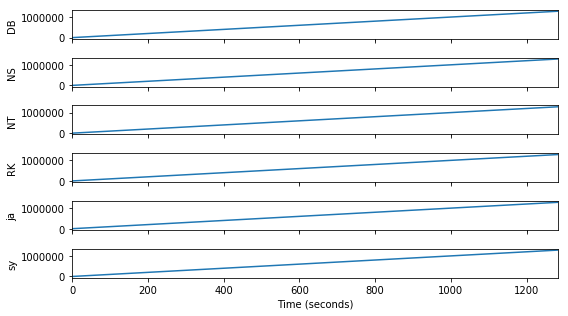

 
******************* audio_intensity *********************


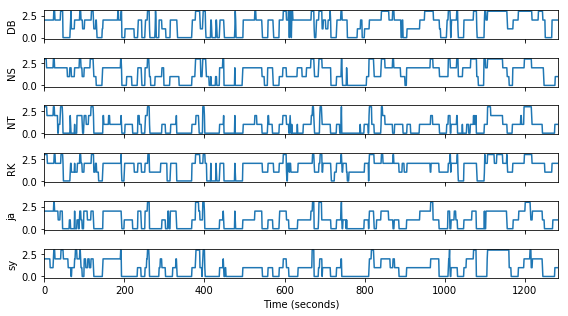

 
******************* audio_valence_negative *********************


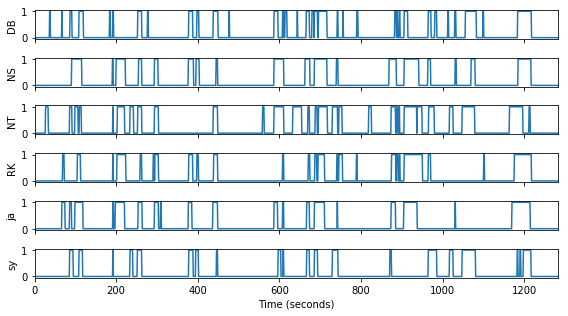

 
******************* audio_valence_positive *********************


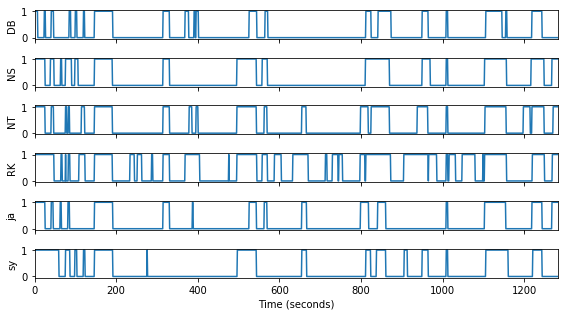

 
******************* visual_intensity *********************


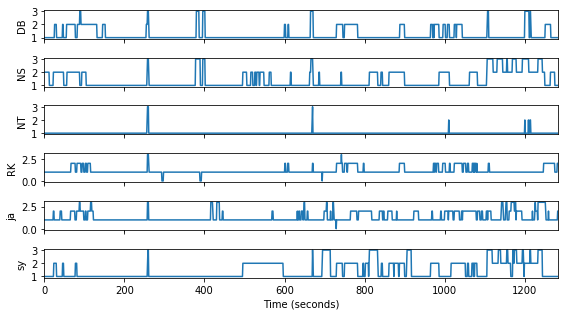

 
******************* visual_valence_negative *********************


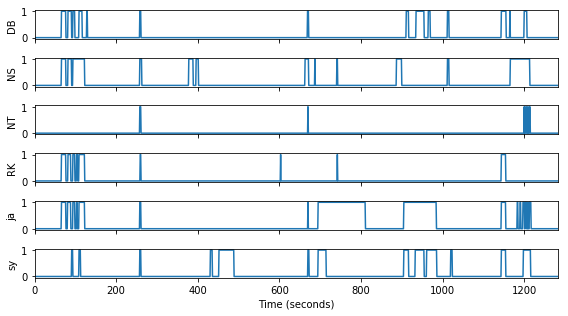

 
******************* visual_valence_positive *********************


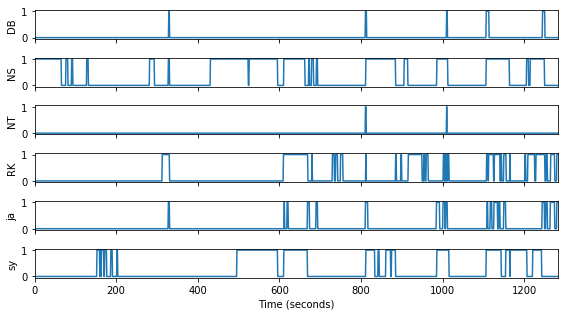

 
******************* seconds *********************


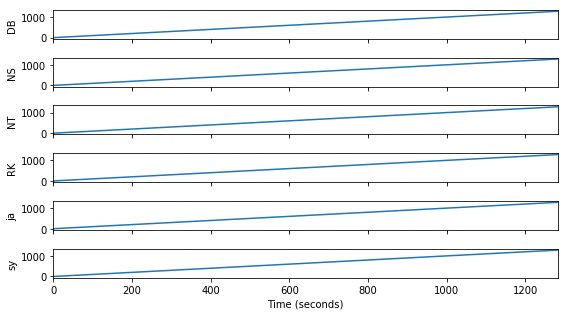

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

dfs = []
raters = []

for file in files:
    rater = file[-22:-20]
    raters.append(rater)
    temp = pd.read_csv(file, index_col=None)
    try:
        temp = temp.drop(string_vars,axis=1)
    except:
        pass
    temp['seconds'] = temp['time']/1000
    temp.index = pd.to_datetime(temp['time'],unit='ms')
    temp.index.name = 'time'
    temp = temp.resample('1s').mean().round(0)
    temp.index = temp['seconds']
    dfs.append(temp)

for x in dfs[0].columns:
    print('******************* {0} *********************'.format(x))
    fig, ax = plt.subplots(len(dfs), figsize=(8, 0.75*len(dfs)))
    for i, rates in enumerate(dfs):
        try:
            rates[x].plot(kind='line', ax=ax[i], xlabel='Time (seconds)', ylabel=raters[i], sharex=True, xlim=(0,rates.index[-1]))
        except:
            pass
    plt.tight_layout()
    fig.title = x
    plt.savefig('ahkj_subjective_nc_codes_{0}.svg'.format(x))
    plt.show()
    print(' ')

In [23]:
# pull in data and combine into 1 dataframe with a rater column
import pandas as pd

dfs = []
dfs_1hz = []
for file in files:
    rater = file[-22:-20]
    temp = pd.read_csv(file, index_col=None)
    try:
        temp = temp.drop(string_vars,axis=1)
    except:
        pass
    temp.index = pd.to_datetime(temp['time'],unit='ms')
    temp.index.name = 'timeseries'
    temp2 = temp.resample('1s').mean().round(0)
    temp['rater'] = rater
    temp2['rater'] = rater
    dfs.append(temp)
    dfs_1hz.append(temp2)
    
data = pd.concat(dfs)
data1hz = pd.concat(dfs_1hz)
data.columns

Index(['time', 'audio_intensity', 'audio_valence_negative',
       'audio_valence_positive', 'visual_intensity', 'visual_valence_negative',
       'visual_valence_positive', 'rater'],
      dtype='object')

In [6]:
# compute ICCs
import pingouin as pg

variables = data.columns[1:-1]

for x in variables:
    print('********************* {0} *********************'.format(x))
    icc = pg.intraclass_corr(data=data, targets='time',raters='rater',ratings=x).round(3)
    print(icc.set_index('Type'))
    print('')

********************* closeup *********************
                   Description    ICC      F    df1    df2  pval         CI95%
Type                                                                          
ICC1    Single raters absolute  0.090  1.592  12834  64175   0.0   [0.08, 0.1]
ICC2      Single random raters  0.145  2.783  12834  64170   0.0  [0.08, 0.21]
ICC3       Single fixed raters  0.229  2.783  12834  64170   0.0  [0.22, 0.24]
ICC1k  Average raters absolute  0.372  1.592  12834  64175   0.0  [0.35, 0.39]
ICC2k    Average random raters  0.505  2.783  12834  64170   0.0  [0.34, 0.62]
ICC3k     Average fixed raters  0.641  2.783  12834  64170   0.0  [0.63, 0.65]

********************* collective *********************
                   Description    ICC       F    df1    df2  pval  \
Type                                                                
ICC1    Single raters absolute  0.860  25.543  12834  38505   0.0   
ICC2      Single random raters  0.860  25.717  12834 

In [24]:
import pandas as pd
variables = data.columns[1:-1]
icc_df = pd.DataFrame(columns=['itemICC','meanICC'])
for x in variables:
    print('********************* {0} *********************'.format(x))
    icc = pg.intraclass_corr(data=data1hz, targets='time',raters='rater',ratings=x, nan_policy='omit').round(3)
    icc_df.loc[x,:]=[icc.loc[1,'ICC'],icc.loc[4,'ICC']]
    print(icc.set_index('Type'))
    print('')

********************* audio_intensity *********************
                   Description    ICC       F   df1   df2  pval         CI95%
Type                                                                         
ICC1    Single raters absolute  0.634  11.413  1283  6420   0.0  [0.61, 0.66]
ICC2      Single random raters  0.641  16.653  1283  6415   0.0  [0.53, 0.72]
ICC3       Single fixed raters  0.723  16.653  1283  6415   0.0   [0.7, 0.74]
ICC1k  Average raters absolute  0.912  11.413  1283  6420   0.0   [0.9, 0.92]
ICC2k    Average random raters  0.915  16.653  1283  6415   0.0  [0.87, 0.94]
ICC3k     Average fixed raters  0.940  16.653  1283  6415   0.0  [0.93, 0.94]

********************* audio_valence_negative *********************
                   Description    ICC      F   df1   df2  pval         CI95%
Type                                                                        
ICC1    Single raters absolute  0.460  6.101  1283  6420   0.0  [0.43, 0.48]
ICC2      Single 

In [25]:
icc_df.to_csv('iccs_ahkj_snc.csv')